---
# <font color="DarkBlue"><b><center>Escuela Politécnica Nacional</center></b></font>
---
## <font color="DarkGreen"><center>Chunk-based Malware Classifiers for Communication Networks</font>

## <font color="DarkGreen"><center>Proyecto de Fin de Módulo Redes Neuronales</font>

**Autor:** David Cevallos

**Fecha:** 2023-08-15

**Google Colab Link:**
https://colab.research.google.com/drive/1K8JqhmAc1dGM1mGmjcN1cdJcsutMvwpc#scrollTo=JJr-rhphgk_l

# Limpieza y preprocesamiento de datos

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn import tree
import imblearn.metrics as imt
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
import sklearn.metrics as mt
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet as cc
from keras.utils import to_categorical,plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE

!pip install scikit-fuzzy

# General seed
np.random.seed(0)

# Importing original data from csv Obfuscated-MalMem2022.csv
original_data = pd.read_csv("/home/Obfuscated-MalMem2022.csv")
data = original_data.copy()

# Malware Families
def classifyFamilies(s):
  if s == "Benign":
    return 0  # Benign
  elif s.startswith("Spyware-180solutions"): # Spyware-180solutions
    return 1
  elif s.startswith("Spyware-CWS"): # Spyware-CWS
    return 2
  elif s.startswith("Spyware-Gator"): # Spyware-Gator
    return 3
  elif s.startswith("Spyware-Transponder"): # Spyware-Transponder
    return 4
  elif s.startswith("Spyware-TIBS"): # Spyware-TIBS
    return 5
  elif s.startswith("Ransomware-Conti"): # Ransomware-Conti
    return 6
  elif s.startswith("Ransomware-Maze"): # Ransomware-Maze
    return 7
  elif s.startswith("Ransomware-Pysa"): # Ransomware-Pysa
    return 8
  elif s.startswith("Ransomware-Ako"): # Ransomware-Ako
    return 9
  elif s.startswith("Ransomware-Shade"): # Ransomware-Shade
    return 10
  elif s.startswith("Trojan-Zeus"): # Trojan-Zeus
    return 11
  elif s.startswith("Trojan-Emotet"): # Trojan-Emotet
    return 12
  elif s.startswith("Trojan-Refroso"): # Trojan-Refroso
    return 13
  elif s.startswith("Trojan-Scar"): # Trojan-Scar
    return 14
  elif s.startswith("Trojan-Reconyc"): # Trojan-Reconyc
    return 15

# Drop unnecesary column
data = data.drop(columns=["Class"])

# Classification data
y = data["Category"].map(lambda s: classifyFamilies(s)).to_numpy()
x = data.drop(columns=["Category"]).to_numpy()

# Visualize general shapes on screen
print("Shape x (features):", x.shape)
print("Shape y (families labels): ", y.shape)

# Splitting (training and test balanced sets definitions)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True, random_state = 1234, stratify = y)

# Number of classes
labels = [
    "Benign",
    "Spyware-180solutions",
    "Spyware-CWS",
    "Spyware-Gator",
    "Spyware-Transponder",
    "Spyware-TIBS",
    "Ransomware-Conti",
    "Ransomware-Maze",
    "Ransomware-Pysa",
    "Ransomware-Ako",
    "Ransomware-Shade",
    "Trojan-Zeus",
    "Trojan-Emotet",
    "Trojan-Refroso",
    "Trojan-Scar",
    "Trojan-Reconyc"
  ]

num_metricas = 8

Shape x (features): (58596, 55)
Shape y (families labels):  (58596,)


In [ ]:
# Function for calculating Metrics - Multiclass classifier
def calcularMetricas(ytrue, ypred, yproba, labels, pictures=False):
  if pictures:
    print("Matriz de confusión")
    cm = mt.confusion_matrix(ytrue, ypred)

    # Matrix confusion
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax,
      square=True,
      cmap="Blues",
      linewidths=0.2,
      annot_kws={"fontsize":5.5})
    ax.set_xlabel("Predicted category", fontsize=8)
    ax.set_ylabel("True category", fontsize=8)
    ax.xaxis.set_ticklabels(labels, fontsize=8)
    ax.yaxis.set_ticklabels(labels, fontsize=8)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

  # Calculating metrics
  precision = mt.precision_score(ytrue, ypred, average="macro")
  recall = mt.recall_score(ytrue, ypred, average="macro")
  f1score = mt.f1_score(ytrue, ypred, average="macro")
  accuracy = mt.accuracy_score(ytrue, ypred)
  error = 1-accuracy
  specificity = imt.specificity_score(ytrue, ypred, average="macro")
  fprm = 1-specificity

  # ROC curve
  numClases = len(labels)

  if pictures:
    numClases_color = numClases

    if numClases < 16:
      numClases_color = 16

    palette = sns.color_palette(cc.glasbey, numClases_color)
    palette = [palette[10],palette[0]]+palette[1:10]+palette[11:]
    fig, ax = plt.subplots()

  ytrue_oneh = to_categorical(ytrue,16)
  auc=0

  for i in np.arange(0,numClases):
    fpr, tpr, thresholds = mt.roc_curve(ytrue_oneh[:, i], yproba[:, i], drop_intermediate=False)
    auc_value = round(mt.auc(fpr, tpr),4)
    auc = auc + auc_value
    if pictures:
      plt.plot(fpr, tpr, color=palette[i], label=labels[i] + " (AUC="+str(auc_value)+")")

  if pictures:
    plt.plot([0,1], [0,1], "--k")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right", prop={'size': 6})
    plt.grid()
    plt.show()

  auc = auc/numClases

  # Present metrics
  print("Valores de métricas obtenidas:")
  print("precision:", precision)
  print("recall:", recall)
  print("f1-score:", f1score)
  print("accuracy:", accuracy)
  print("error:", error)
  print("specificity:", specificity)
  print("false positive rate:", fprm)
  print("auc:", auc)

  return np.array([[precision],[recall],[f1score],[accuracy],[error],[specificity],[fprm],[auc]])

# Árbol de Decisión

In [ ]:
# K-fold cross validation (10 iterations)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
metricas = np.array([], dtype=np.int64).reshape(num_metricas,0)

# 10-Fold iterations
for i, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
  print("----------------------------------------------------")
  print("Decision Tree - Resultados para Fold Nro.",str(i+1))
  print("----------------------------------------------------")
  # Decision tree
  modelo = tree.DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=15)
  modelo.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = modelo.predict(x_train[val_index])
  yproba = modelo.predict_proba(x_train[val_index])
  # Calculate metrics
  resultado = calcularMetricas(ytrue, ypred, yproba, labels)
  metricas = np.hstack((metricas,resultado))

# Matriz con resultados de métricas
# Rows: Metric (precision, recall, etc)
# Columns: k-fold (iteration)
print("")
print("----------------------------------------------------")
print("Resultado final matriz de métricas obtenidas:")
print("Filas (Métrica) vs Columnas (Nro. de fold)")
print("----------------------------------------------------")
print(metricas)
print("")
print("----------------------------------------------------")
print("Se computa la media total para cada métrica:")
print("----------------------------------------------------")
totales = np.mean(metricas,1).reshape(num_metricas,-1)
print("mean-precision:",totales[0,0])
print("mean-recall:",totales[1,0])
print("mean-f1-score:",totales[2,0])
print("mean-accuracy:",totales[3,0])
print("mean-error:",totales[4,0])
print("mean-specificity:",totales[5,0])
print("mean-false positive rate:",totales[6,0])
print("mean-auc:",totales[7,0])

----------------------------------------------------
Decision Tree - Resultados para Fold Nro. 1
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.49695096785194837
recall: 0.48650881457824036
f1-score: 0.48717996135595243
accuracy: 0.7246160409556314
error: 0.27538395904436863
specificity: 0.9821774491547918
false positive rate: 0.01782255084520823
auc: 0.8789124999999999
----------------------------------------------------
Decision Tree - Resultados para Fold Nro. 2
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.486412812448123
recall: 0.47601150515759594
f1-score: 0.4742520993956958
accuracy: 0.7199232081911263
error: 0.2800767918088737
specificity: 0.9818569436430596
false positive rate: 0.018143056356940357
auc: 0.8889374999999998
----------------------------------------------------
Decision Tree - Resultados para Fold Nro. 3
----------------------------------------------------
Valores

----------------------------------------------------
Decision Tree - Resultados para Test
----------------------------------------------------
Matriz de confusión


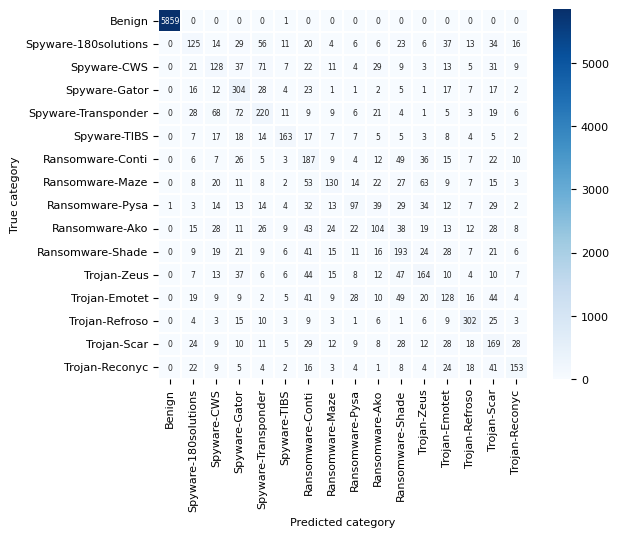

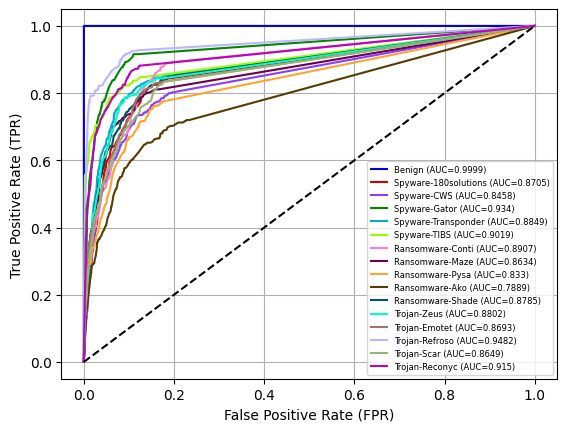

Valores de métricas obtenidas:
precision: 0.4836449009302681
recall: 0.47287439068578874
f1-score: 0.4722825814557847
accuracy: 0.7189419795221843
error: 0.2810580204778157
specificity: 0.9818023363983196
false positive rate: 0.018197663601680403
auc: 0.8855687500000002


In [ ]:
print("----------------------------------------------------")
print("Decision Tree - Resultados para Test")
print("----------------------------------------------------")
modelo = tree.DecisionTreeClassifier(criterion="entropy", random_state=0, max_depth=15)
modelo.fit(x_train,y_train)
ytrue = y_test
ypred = modelo.predict(x_test)
yproba = modelo.predict_proba(x_test)
resultado = calcularMetricas(ytrue, ypred, yproba, labels, True)
metricas = resultado.reshape(-1,1)

# Random Forest

In [ ]:
# K-fold cross validation (10 iterations)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
metricas = np.array([], dtype=np.int64).reshape(num_metricas,0)

# 10-Fold iterations
for i, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
  print("----------------------------------------------------")
  print("Decision Tree - Resultados para Fold Nro.",str(i+1))
  print("----------------------------------------------------")
  # Random Forest classifier
  modelo = RandomForestClassifier(n_estimators=130, criterion="entropy", random_state=0, max_depth=15)
  modelo.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = modelo.predict(x_train[val_index])
  yproba = modelo.predict_proba(x_train[val_index])
  # Calculate metrics
  resultado = calcularMetricas(ytrue, ypred, yproba, labels)
  metricas = np.hstack((metricas,resultado))

# Matriz con resultados de métricas
# Rows: Metric (precision, recall, etc)
# Columns: k-fold (iteration)
print("")
print("----------------------------------------------------")
print("Resultado final matriz de métricas obtenidas:")
print("Filas (Métrica) vs Columnas (Nro. de fold)")
print("----------------------------------------------------")
print(metricas)
print("")
print("----------------------------------------------------")
print("Se computa la media total para cada métrica:")
print("----------------------------------------------------")
totales = np.mean(metricas,1).reshape(num_metricas,-1)
print("mean-precision:",totales[0,0])
print("mean-recall:",totales[1,0])
print("mean-f1-score:",totales[2,0])
print("mean-accuracy:",totales[3,0])
print("mean-error:",totales[4,0])
print("mean-specificity:",totales[5,0])
print("mean-false positive rate:",totales[6,0])
print("mean-auc:",totales[7,0])

----------------------------------------------------
Decision Tree - Resultados para Fold Nro. 1
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.5615552957626672
recall: 0.5480711061097733
f1-score: 0.5412244747485719
accuracy: 0.7587457337883959
error: 0.24125426621160406
specificity: 0.9843815593378291
false positive rate: 0.015618440662170885
auc: 0.9559500000000001
----------------------------------------------------
Decision Tree - Resultados para Fold Nro. 2
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.539184640806487
recall: 0.5226558023649661
f1-score: 0.5190053789469798
accuracy: 0.7459470989761092
error: 0.2540529010238908
specificity: 0.9835254140118028
false positive rate: 0.016474585988197177
auc: 0.9517875000000001
----------------------------------------------------
Decision Tree - Resultados para Fold Nro. 3
----------------------------------------------------
Valores de

----------------------------------------------------
Random Forest - Resultados para Test
----------------------------------------------------
Matriz de confusión


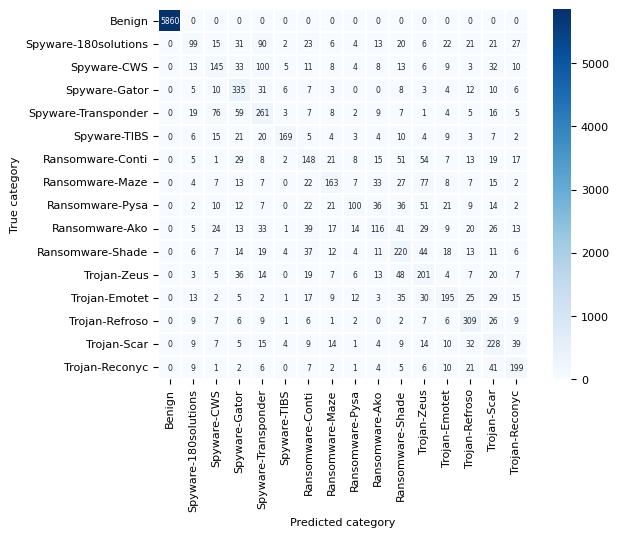

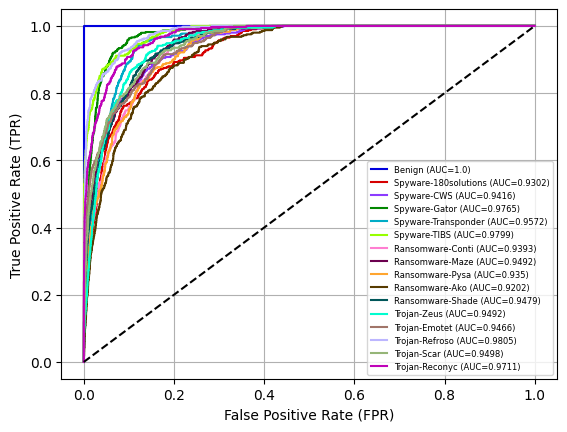

Valores de métricas obtenidas:
precision: 0.542964967985982
recall: 0.5241016695696276
f1-score: 0.5208885007451576
accuracy: 0.7464163822525597
error: 0.2535836177474403
specificity: 0.9835800542552606
false positive rate: 0.016419945744739373
auc: 0.9546374999999999


In [ ]:
print("----------------------------------------------------")
print("Random Forest - Resultados para Test")
print("----------------------------------------------------")
modelo = RandomForestClassifier(n_estimators=130, criterion="entropy", random_state=0, max_depth=15)
modelo.fit(x_train,y_train)
ytrue = y_test
ypred = modelo.predict(x_test)
yproba = modelo.predict_proba(x_test)
resultado = calcularMetricas(ytrue, ypred, yproba, labels, True)
metricas = resultado.reshape(-1,1)

# LDA

In [ ]:
# K-fold cross validation (10 iterations)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
metricas = np.array([], dtype=np.int64).reshape(num_metricas,0)

# 10-Fold iterations
for i, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
  print("----------------------------------------------------")
  print("LDA Classifier - Resultados para Fold Nro.",str(i+1))
  print("----------------------------------------------------")
  # SVC
  modelo = Pipeline([
     ("scaler", StandardScaler()),
     ("clf", LinearDiscriminantAnalysis())
  ])
  modelo.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = modelo.predict(x_train[val_index])
  yproba = modelo.predict_proba(x_train[val_index])
  # Calculate metrics
  resultado = calcularMetricas(ytrue, ypred, yproba, labels)
  metricas = np.hstack((metricas,resultado))

# Matriz con resultados de métricas
# Rows: Metric (precision, recall, etc)
# Columns: k-fold (iteration)
print("")
print("----------------------------------------------------")
print("Resultado final matriz de métricas obtenidas:")
print("Filas (Métrica) vs Columnas (Nro. de fold)")
print("----------------------------------------------------")
print(metricas)
print("")
print("----------------------------------------------------")
print("Se computa la media total para cada métrica:")
print("----------------------------------------------------")
totales = np.mean(metricas,1).reshape(num_metricas,-1)
print("mean-precision:",totales[0,0])
print("mean-recall:",totales[1,0])
print("mean-f1-score:",totales[2,0])
print("mean-accuracy:",totales[3,0])
print("mean-error:",totales[4,0])
print("mean-specificity:",totales[5,0])
print("mean-false positive rate:",totales[6,0])
print("mean-auc:",totales[7,0])

----------------------------------------------------
LDA Classifier - Resultados para Fold Nro. 1
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.33853474897031516
recall: 0.2564098860283771
f1-score: 0.24810330488715468
accuracy: 0.6013225255972696
error: 0.3986774744027304
specificity: 0.9740460756520044
false positive rate: 0.025953924347995594
auc: 0.8572812499999999
----------------------------------------------------
LDA Classifier - Resultados para Fold Nro. 2
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.3399075586324634
recall: 0.24116309806535613
f1-score: 0.23388907812514703
accuracy: 0.5936433447098977
error: 0.40635665529010234
specificity: 0.9735160469700398
false positive rate: 0.026483953029960206
auc: 0.8530375000000001
----------------------------------------------------
LDA Classifier - Resultados para Fold Nro. 3
----------------------------------------------------
Va

----------------------------------------------------
LDA Classifier - Resultados para Test
----------------------------------------------------
Matriz de confusión


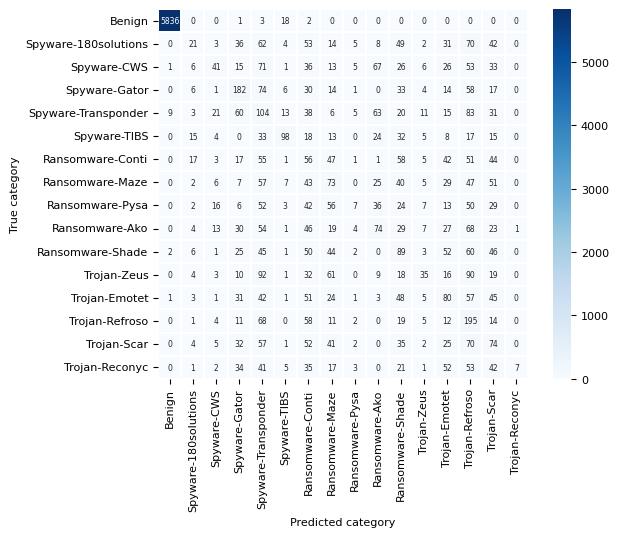

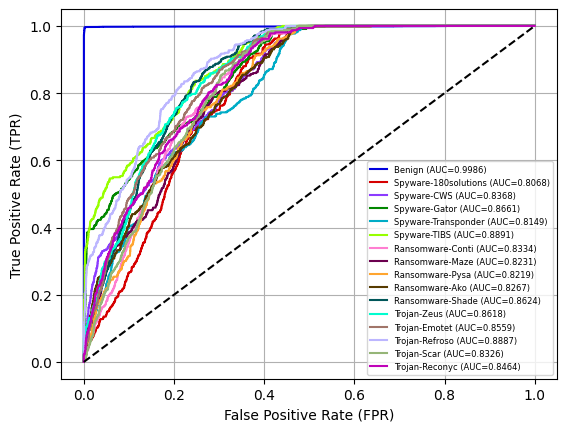

Valores de métricas obtenidas:
precision: 0.32512596607573785
recall: 0.2410738405394583
f1-score: 0.2337251585383854
accuracy: 0.5948805460750853
error: 0.40511945392491466
specificity: 0.9736821835269637
false positive rate: 0.026317816473036326
auc: 0.8540749999999999


In [ ]:
print("----------------------------------------------------")
print("LDA Classifier - Resultados para Test")
print("----------------------------------------------------")
modelo = Pipeline([
     ("scaler", StandardScaler()),
     ("clf", LinearDiscriminantAnalysis())
  ])
modelo.fit(x_train,y_train)
ytrue = y_test
ypred = modelo.predict(x_test)
yproba = modelo.predict_proba(x_test)
resultado = calcularMetricas(ytrue, ypred, yproba, labels, True)
metricas = resultado.reshape(-1,1)

# SVC

In [ ]:
# K-fold cross validation (10 iterations)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
metricas = np.array([], dtype=np.int64).reshape(num_metricas,0)

# 10-Fold iterations
for i, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
  print("----------------------------------------------------")
  print("SVM Classifier (SVC) - Resultados para Fold Nro.",str(i+1))
  print("----------------------------------------------------")
  # SVC
  modelo = Pipeline([
     ("scaler", StandardScaler()),
     ("clf", SVC(kernel="rbf", random_state=45, probability=True))
  ])
  modelo.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = modelo.predict(x_train[val_index])
  yproba = modelo.predict_proba(x_train[val_index])
  # Calculate metrics
  resultado = calcularMetricas(ytrue, ypred, yproba, labels)
  metricas = np.hstack((metricas,resultado))

# Matriz con resultados de métricas
# Rows: Metric (precision, recall, etc)
# Columns: k-fold (iteration)
print("")
print("----------------------------------------------------")
print("Resultado final matriz de métricas obtenidas:")
print("Filas (Métrica) vs Columnas (Nro. de fold)")
print("----------------------------------------------------")
print(metricas)
print("")
print("----------------------------------------------------")
print("Se computa la media total para cada métrica:")
print("----------------------------------------------------")
totales = np.mean(metricas,1).reshape(num_metricas,-1)
print("mean-precision:",totales[0,0])
print("mean-recall:",totales[1,0])
print("mean-f1-score:",totales[2,0])
print("mean-accuracy:",totales[3,0])
print("mean-error:",totales[4,0])
print("mean-specificity:",totales[5,0])
print("mean-false positive rate:",totales[6,0])
print("mean-auc:",totales[7,0])

----------------------------------------------------
SVM Classifier (SVC) - Resultados para Fold Nro. 1
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.43121952125040464
recall: 0.29305594196875123
f1-score: 0.2956788423642701
accuracy: 0.6235068259385665
error: 0.37649317406143346
specificity: 0.9755917812132749
false positive rate: 0.024408218786725056
auc: 0.878375
----------------------------------------------------
SVM Classifier (SVC) - Resultados para Fold Nro. 2
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.4516963733712428
recall: 0.2961988260240574
f1-score: 0.30223243524060583
accuracy: 0.6258532423208191
error: 0.37414675767918093
specificity: 0.9757169897533939
false positive rate: 0.024283010246606063
auc: 0.8764124999999999
----------------------------------------------------
SVM Classifier (SVC) - Resultados para Fold Nro. 3
-----------------------------------------------

----------------------------------------------------
SVM Classifier (SVC) - Resultados para Test
----------------------------------------------------
Matriz de confusión


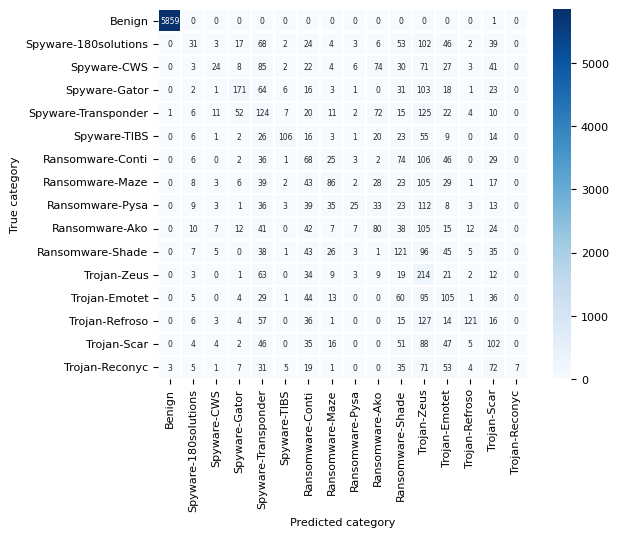

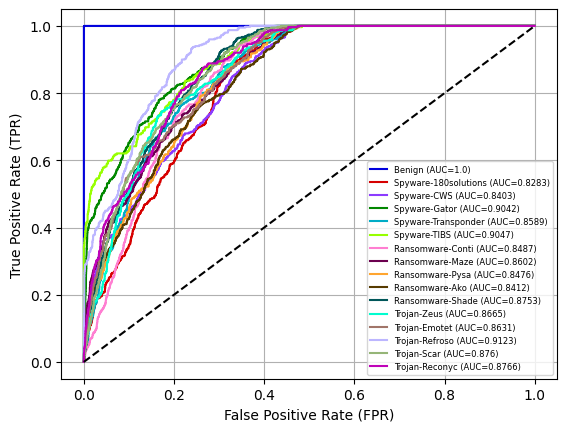

Valores de métricas obtenidas:
precision: 0.427678399854441
recall: 0.2813728780107029
f1-score: 0.28453014379744823
accuracy: 0.6180887372013651
error: 0.38191126279863485
specificity: 0.9752430398034659
false positive rate: 0.02475696019653406
auc: 0.8752437499999999


In [ ]:
print("----------------------------------------------------")
print("SVM Classifier (SVC) - Resultados para Test")
print("----------------------------------------------------")
modelo = Pipeline([
     ("scaler", StandardScaler()),
     ("clf", SVC(kernel="rbf", random_state=45, probability=True))
  ])
modelo.fit(x_train,y_train)
ytrue = y_test
ypred = modelo.predict(x_test)
yproba = modelo.predict_proba(x_test)
resultado = calcularMetricas(ytrue, ypred, yproba, labels, True)
metricas = resultado.reshape(-1,1)

# Naive Bayes

In [ ]:
# K-fold cross validation (10 iterations)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
metricas = np.array([], dtype=np.int64).reshape(num_metricas,0)

# 10-Fold iterations
for i, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
  print("----------------------------------------------------")
  print("Naive Bayes Classifier - Resultados para Fold Nro.",str(i+1))
  print("----------------------------------------------------")
  # SVC
  modelo = Pipeline([
     ("scaler", StandardScaler()),
     ("clf", GaussianNB())
  ])
  modelo.fit(x_train[train_index],y_train[train_index])
  # Labels obtained
  ytrue = y_train[val_index]
  ypred = modelo.predict(x_train[val_index])
  yproba = modelo.predict_proba(x_train[val_index])
  # Calculate metrics
  resultado = calcularMetricas(ytrue, ypred, yproba, labels)
  metricas = np.hstack((metricas,resultado))

# Matriz con resultados de métricas
# Rows: Metric (precision, recall, etc)
# Columns: k-fold (iteration)
print("")
print("----------------------------------------------------")
print("Resultado final matriz de métricas obtenidas:")
print("Filas (Métrica) vs Columnas (Nro. de fold)")
print("----------------------------------------------------")
print(metricas)
print("")
print("----------------------------------------------------")
print("Se computa la media total para cada métrica:")
print("----------------------------------------------------")
totales = np.mean(metricas,1).reshape(num_metricas,-1)
print("mean-precision:",totales[0,0])
print("mean-recall:",totales[1,0])
print("mean-f1-score:",totales[2,0])
print("mean-accuracy:",totales[3,0])
print("mean-error:",totales[4,0])
print("mean-specificity:",totales[5,0])
print("mean-false positive rate:",totales[6,0])
print("mean-auc:",totales[7,0])

----------------------------------------------------
Naive Bayes Classifier - Resultados para Fold Nro. 1
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.3179256783398408
recall: 0.20683975030630347
f1-score: 0.15792339053544288
accuracy: 0.5669795221843004
error: 0.43302047781569963
specificity: 0.9719678279541093
false positive rate: 0.028032172045890702
auc: 0.8340249999999999
----------------------------------------------------
Naive Bayes Classifier - Resultados para Fold Nro. 2
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.30190541212549066
recall: 0.2091435355773223
f1-score: 0.15400537757878655
accuracy: 0.570179180887372
error: 0.42982081911262804
specificity: 0.9721651880444777
false positive rate: 0.027834811955522287
auc: 0.83399375
----------------------------------------------------
Naive Bayes Classifier - Resultados para Fold Nro. 3
---------------------------------------

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Valores de métricas obtenidas:
precision: 0.27805687510399085
recall: 0.20286194689336629
f1-score: 0.15720521978689841
accuracy: 0.5678327645051194
error: 0.43216723549488056
specificity: 0.9719875440684249
false positive rate: 0.028012455931575087
auc: 0.8270499999999998
----------------------------------------------------
Naive Bayes Classifier - Resultados para Fold Nro. 4
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.3121338266507605
recall: 0.198735954700391
f1-score: 0.15209179673164125
accuracy: 0.5633532423208191
error: 0.43664675767918093
specificity: 0.9717107956932325
false positive rate: 0.028289204306767513
auc: 0.8285875
----------------------------------------------------
Naive Bayes Classifier - Resultados para Fold Nro. 5
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.3138016527573728
recall: 0.20280802270365295
f1-score: 0.15171679765904164
accuracy: 0.562713310580204

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Valores de métricas obtenidas:
precision: 0.26200768059496954
recall: 0.19944646484051604
f1-score: 0.14325224091688196
accuracy: 0.5634734371666311
error: 0.4365265628333689
specificity: 0.9717110464375052
false positive rate: 0.028288953562494834
auc: 0.8314812500000001
----------------------------------------------------
Naive Bayes Classifier - Resultados para Fold Nro. 10
----------------------------------------------------
Valores de métricas obtenidas:
precision: 0.3071185069128305
recall: 0.2015780043988133
f1-score: 0.14708084002540997
accuracy: 0.5673138468103265
error: 0.4326861531896735
specificity: 0.9719880576164877
false positive rate: 0.028011942383512345
auc: 0.83361875

----------------------------------------------------
Resultado final matriz de métricas obtenidas:
Filas (Métrica) vs Columnas (Nro. de fold)
----------------------------------------------------
[[0.31792568 0.30190541 0.27805688 0.31213383 0.31380165 0.28528212
  0.25281667 0.31324904 0.26200768 0.307

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



----------------------------------------------------
Naive Bayes Classifier - Resultados para Test
----------------------------------------------------
Matriz de confusión


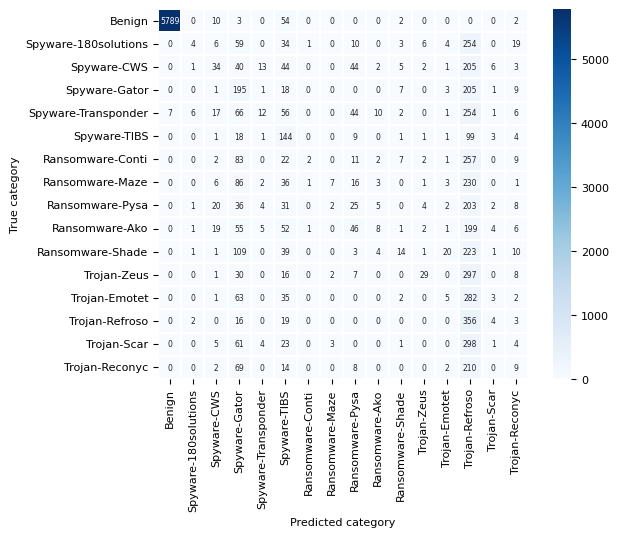

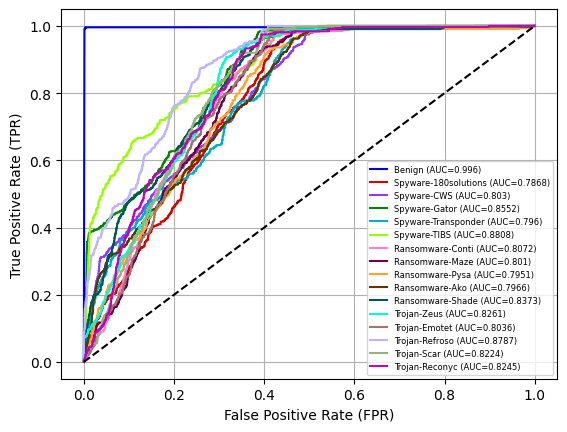

Valores de métricas obtenidas:
precision: 0.29558727834493825
recall: 0.20115479983355627
f1-score: 0.1490875389377855
accuracy: 0.5660409556313993
error: 0.43395904436860067
specificity: 0.9719037382529574
false positive rate: 0.028096261747042606
auc: 0.8318937500000001


In [ ]:
print("----------------------------------------------------")
print("Naive Bayes Classifier - Resultados para Test")
print("----------------------------------------------------")
modelo = Pipeline([
     ("scaler", StandardScaler()),
     ("clf", GaussianNB())
  ])
modelo.fit(x_train,y_train)
ytrue = y_test
ypred = modelo.predict(x_test)
yproba = modelo.predict_proba(x_test)
resultado = calcularMetricas(ytrue, ypred, yproba, labels, True)
metricas = resultado.reshape(-1,1)

# ANFIS
Código fuente disponible en:
https://github.com/twmeggs/anfis/blob/master/anfis/anfis.py

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 31 15:41:58 2014

@author: tim.meggs
"""

from skfuzzy import gaussmf, gbellmf, sigmf

class MemFuncs:
    'Common base class for all employees'
    funcDict = {'gaussmf': gaussmf, 'gbellmf': gbellmf, 'sigmf': sigmf}


    def __init__(self, MFList):
        self.MFList = MFList

    def evaluateMF(self, rowInput):
        if len(rowInput) != len(self.MFList):
            print("Number of variables does not match number of rule sets")

        return [[self.funcDict[self.MFList[i][k][0]](rowInput[i],**self.MFList[i][k][1]) for k in range(len(self.MFList[i]))] for i in range(len(rowInput))]

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 03 07:30:34 2014

@author: tim.meggs
"""
import itertools
import numpy as np
import copy

class ANFIS(LinearDiscriminantAnalysis):
    """Class to implement an Adaptive Network Fuzzy Inference System: ANFIS"

    Attributes:
        X
        Y
        XLen
        memClass
        memFuncs
        memFuncsByVariable
        rules
        consequents
        errors
        memFuncsHomo
        trainingType


    """
    def __init__(self, X, Y, memFunction="gaussmf"):
        self.X = np.array(copy.copy(X))
        self.Y = np.array(copy.copy(Y))
        self.XLen = len(self.X)
        self.memClass = copy.deepcopy(memFunction)
        self.memFuncs = self.memClass.MFList
        self.memFuncsByVariable = [[x for x in range(len(self.memFuncs[z]))] for z in range(len(self.memFuncs))]
        self.rules = np.array(list(itertools.product(*self.memFuncsByVariable)))
        self.consequents = np.empty(self.Y.ndim * len(self.rules) * (self.X.shape[1] + 1))
        self.consequents.fill(0)
        self.errors = np.empty(0)
        self.memFuncsHomo = all(len(i)==len(self.memFuncsByVariable[0]) for i in self.memFuncsByVariable)
        self.trainingType = 'Not trained yet'

    def LSE(self, A, B, initialGamma = 1000.):
        coeffMat = A
        rhsMat = B
        S = np.eye(coeffMat.shape[1])*initialGamma
        x = np.zeros((coeffMat.shape[1],1)) # need to correct for multi-dim B
        for i in range(len(coeffMat[:,0])):
            a = coeffMat[i,:]
            b = np.array(rhsMat[i])
            S = S - (np.array(np.dot(np.dot(np.dot(S,np.matrix(a).transpose()),np.matrix(a)),S)))/(1+(np.dot(np.dot(S,a),a)))
            x = x + (np.dot(S,np.dot(np.matrix(a).transpose(),(np.matrix(b)-np.dot(np.matrix(a),x)))))
        return x

    def trainHybridJangOffLine(self, epochs=100, tolerance=1e-5, initialGamma=1000, k=0.01):

        self.trainingType = 'trainHybridJangOffLine'
        convergence = False
        epoch = 1

        while (epoch < epochs) and (convergence is not True):

            #layer four: forward pass
            [layerFour, wSum, w] = forwardHalfPass(self, self.X)

            #layer five: least squares estimate
            layerFive = np.array(self.LSE(layerFour,self.Y,initialGamma))
            self.consequents = layerFive
            layerFive = np.dot(layerFour,layerFive)

            #error
            error = np.sum((self.Y-layerFive.T)**2)
            print('current error: '+ str(error))
            average_error = np.average(np.absolute(self.Y-layerFive.T))
            self.errors = np.append(self.errors,error)

            if len(self.errors) != 0:
                if self.errors[len(self.errors)-1] < tolerance:
                    convergence = True

            # back propagation
            if convergence is not True:
                cols = range(len(self.X[0,:]))
                dE_dAlpha = list(backprop(self, colX, cols, wSum, w, layerFive) for colX in range(self.X.shape[1]))


            if len(self.errors) >= 4:
                if (self.errors[-4] > self.errors[-3] > self.errors[-2] > self.errors[-1]):
                    k = k * 1.1

            if len(self.errors) >= 5:
                if (self.errors[-1] < self.errors[-2]) and (self.errors[-3] < self.errors[-2]) and (self.errors[-3] < self.errors[-4]) and (self.errors[-5] > self.errors[-4]):
                    k = k * 0.9

            ## handling of variables with a different number of MFs
            t = []
            for x in range(len(dE_dAlpha)):
                for y in range(len(dE_dAlpha[x])):
                    for z in range(len(dE_dAlpha[x][y])):
                        t.append(dE_dAlpha[x][y][z])

            eta = k / np.abs(np.sum(t))

            if(np.isinf(eta)):
                eta = k

            ## handling of variables with a different number of MFs
            dAlpha = copy.deepcopy(dE_dAlpha)
            if not(self.memFuncsHomo):
                for x in range(len(dE_dAlpha)):
                    for y in range(len(dE_dAlpha[x])):
                        for z in range(len(dE_dAlpha[x][y])):
                            dAlpha[x][y][z] = -eta * dE_dAlpha[x][y][z]
            else:
                dAlpha = -eta * np.array(dE_dAlpha)


            for varsWithMemFuncs in range(len(self.memFuncs)):
                for MFs in range(len(self.memFuncsByVariable[varsWithMemFuncs])):
                    paramList = sorted(self.memFuncs[varsWithMemFuncs][MFs][1])
                    for param in range(len(paramList)):
                        self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] = self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] + dAlpha[varsWithMemFuncs][MFs][param]
            epoch = epoch + 1


        self.fittedValues = predict(self,self.X)
        self.residuals = self.Y - self.fittedValues[:,0]

        return self.fittedValues


    def plotErrors(self):
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.errors)),self.errors,'ro', label='errors')
            plt.ylabel('error')
            plt.xlabel('epoch')
            plt.show()

    def plotMF(self, x, inputVar):
        import matplotlib.pyplot as plt
        from skfuzzy import gaussmf, gbellmf, sigmf

        for mf in range(len(self.memFuncs[inputVar])):
            if self.memFuncs[inputVar][mf][0] == 'gaussmf':
                y = gaussmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'gbellmf':
                y = gbellmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'sigmf':
                y = sigmf(x,**self.memClass.MFList[inputVar][mf][1])

            plt.plot(x,y,'r')

        plt.show()

    def plotResults(self):
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.fittedValues)),self.fittedValues,'r', label='trained')
            plt.plot(range(len(self.Y)),self.Y,'b', label='original')
            plt.legend(loc='upper left')
            plt.show()



def forwardHalfPass(ANFISObj, Xs):
    layerFour = np.empty(0,)
    wSum = []

    for pattern in range(len(Xs[:,0])):
        #layer one
        layerOne = ANFISObj.memClass.evaluateMF(Xs[pattern,:])

        #layer two
        miAlloc = [[layerOne[x][ANFISObj.rules[row][x]] for x in range(len(ANFISObj.rules[0]))] for row in range(len(ANFISObj.rules))]
        layerTwo = np.array([np.product(x) for x in miAlloc]).T
        if pattern == 0:
            w = layerTwo
        else:
            w = np.vstack((w,layerTwo))

        #layer three
        wSum.append(np.sum(layerTwo))
        if pattern == 0:
            wNormalized = layerTwo/wSum[pattern]
        else:
            wNormalized = np.vstack((wNormalized,layerTwo/wSum[pattern]))

        #prep for layer four (bit of a hack)
        layerThree = layerTwo/wSum[pattern]
        rowHolder = np.concatenate([x*np.append(Xs[pattern,:],1) for x in layerThree])
        layerFour = np.append(layerFour,rowHolder)

    w = w.T
    wNormalized = wNormalized.T

    layerFour = np.array(np.array_split(layerFour,pattern + 1))

    return layerFour, wSum, w


def backprop(ANFISObj, columnX, columns, theWSum, theW, theLayerFive):

    paramGrp = [0]* len(ANFISObj.memFuncs[columnX])
    for MF in range(len(ANFISObj.memFuncs[columnX])):

        parameters = np.empty(len(ANFISObj.memFuncs[columnX][MF][1]))
        timesThru = 0
        for alpha in sorted(ANFISObj.memFuncs[columnX][MF][1].keys()):

            bucket3 = np.empty(len(ANFISObj.X))
            for rowX in range(len(ANFISObj.X)):
                varToTest = ANFISObj.X[rowX,columnX]
                tmpRow = np.empty(len(ANFISObj.memFuncs))
                tmpRow.fill(varToTest)

                bucket2 = np.empty(ANFISObj.Y.ndim)
                for colY in range(ANFISObj.Y.ndim):

                    rulesWithAlpha = np.array(np.where(ANFISObj.rules[:,columnX]==MF))[0]
                    adjCols = np.delete(columns,columnX)

                    senSit = mfDerivs.partial_dMF(ANFISObj.X[rowX,columnX],ANFISObj.memFuncs[columnX][MF],alpha)
                    # produces d_ruleOutput/d_parameterWithinMF
                    dW_dAplha = senSit * np.array([np.prod([ANFISObj.memClass.evaluateMF(tmpRow)[c][ANFISObj.rules[r][c]] for c in adjCols]) for r in rulesWithAlpha])

                    bucket1 = np.empty(len(ANFISObj.rules[:,0]))
                    for consequent in range(len(ANFISObj.rules[:,0])):
                        fConsequent = np.dot(np.append(ANFISObj.X[rowX,:],1.),ANFISObj.consequents[((ANFISObj.X.shape[1] + 1) * consequent):(((ANFISObj.X.shape[1] + 1) * consequent) + (ANFISObj.X.shape[1] + 1)),colY])
                        acum = 0
                        if consequent in rulesWithAlpha:
                            acum = dW_dAplha[np.where(rulesWithAlpha==consequent)] * theWSum[rowX]

                        acum = acum - theW[consequent,rowX] * np.sum(dW_dAplha)
                        acum = acum / theWSum[rowX]**2
                        bucket1[consequent] = fConsequent * acum

                    sum1 = np.sum(bucket1)

                    if ANFISObj.Y.ndim == 1:
                        bucket2[colY] = sum1 * (ANFISObj.Y[rowX]-theLayerFive[rowX,colY])*(-2)
                    else:
                        bucket2[colY] = sum1 * (ANFISObj.Y[rowX,colY]-theLayerFive[rowX,colY])*(-2)

                sum2 = np.sum(bucket2)
                bucket3[rowX] = sum2

            sum3 = np.sum(bucket3)
            parameters[timesThru] = sum3
            timesThru = timesThru + 1

        paramGrp[MF] = parameters

    return paramGrp


def predict(ANFISObj, varsToTest):

    [layerFour, wSum, w] = forwardHalfPass(ANFISObj, varsToTest)

    #layer five
    layerFive = np.dot(layerFour,ANFISObj.consequents)

    return layerFive


if __name__ == "__main__":
    print("I am main!")


I am main!


----------------------------------------------------
ANFIS - Resultados para Test
----------------------------------------------------
Matriz de confusión


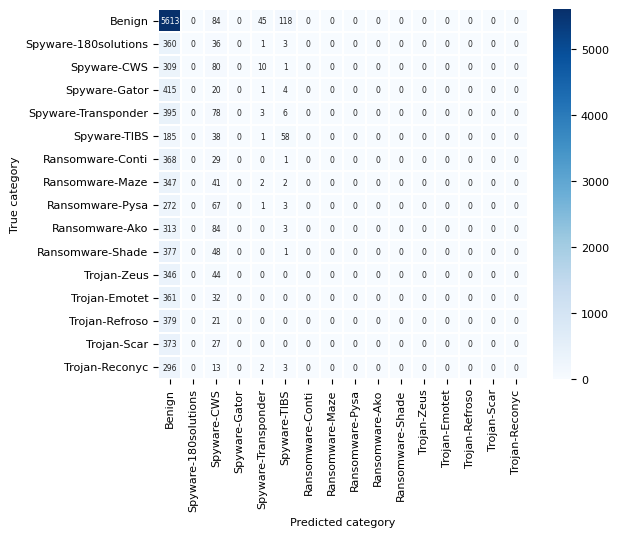

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


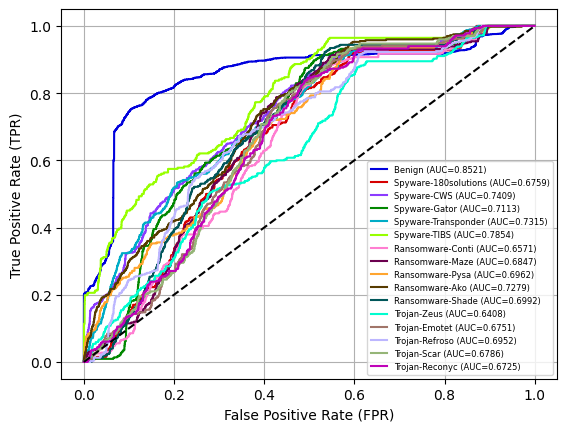

Valores de métricas obtenidas:
precision: 0.06019525736184225
recall: 0.08560922841292659
f1-score: 0.06673497308568728
accuracy: 0.4909556313993174
error: 0.5090443686006826
specificity: 0.9408507400061019
false positive rate: 0.059149259993898085
auc: 0.7077749999999999


In [ ]:
np.random.seed(0);

xred=TSNE(n_components=2, learning_rate="auto", init="random", perplexity=100, random_state=0).fit_transform(x);
x_train_tsne, x_test_tsne, y_train_tsne, y_test_tsne = train_test_split(xred, y, train_size=0.8, shuffle=True, random_state = 1234, stratify = y);

np.random.seed(0);
print("----------------------------------------------------")
print("ANFIS - Resultados para Test")
print("----------------------------------------------------")

# Se ejecuta ANFIS con su configuración por defecto
modelo = Pipeline([("clf", ANFIS())])

modelo.fit(x_train_tsne,y_train_tsne)
ytrue_tsne = y_test_tsne
ypred_tsne = modelo.predict(x_test_tsne)
yproba_tsne = modelo.predict_proba(x_test_tsne)
resultado = calcularMetricas(ytrue_tsne, ypred_tsne, yproba_tsne, labels, True)
metricas = resultado.reshape(-1,1)

# Gráficos radiales

In [ ]:
# Gráfico radial de métricas de cross-validation
import plotly.graph_objects as go

categories = ["Precision","Recall","F1-score","Specificity","AUC","Precision"]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[0.4315,0.2879,0.2908,0.9755,0.8760,0.4315],
      theta=categories,
      name="SVC"
))
fig.add_trace(go.Scatterpolar(
      r=[0.4850,0.4759,0.4748,0.9819,0.8855,0.4850],
      theta=categories,
      name="DT"
))
fig.add_trace(go.Scatterpolar(
      r=[0.5443,0.5284,0.5229,0.9837,0.9541,0.5443],
      theta=categories,
      name="RF"
))
fig.add_trace(go.Scatterpolar(
      r=[0.3325,0.2457,0.2387,0.9738,0.8547,0.3325],
      theta=categories,
      name="LDA"
))
fig.add_trace(go.Scatterpolar(
      r=[0.2944,0.2006,0.1492,0.9718,0.8321,0.2944],
      theta=categories,
      name="NB"
))
fig.add_trace(go.Scatterpolar(
      r=[0.6202,0.6202,0.6202,0.9867,0.8981,0.6202],
      theta=categories,
      name="DNN"
))
fig.add_trace(go.Scatterpolar(
      r=[0.2031,0.0941,0.2406,0.9246,0.7078,0.2031],
      theta=categories,
      name="ANFIS"
))
fig.add_trace(go.Scatterpolar(
      r=[0.6830,0.6830,0.6830,0.9921,0.9344,0.6830],
      theta=categories,
      name="S-DNN"
))

fig.update_layout(
  polar=dict(
    radialaxis_angle = 0,
    angularaxis = dict(
        rotation = -135,
        direction = "clockwise",
        tickfont_size=20,
        tickfont_color="black",
        tickfont_family="DejaVu Sans",
      ),
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  legend=dict(
      y=1.07,
      x=0.8,
      font=dict(
      family="DejaVu Sans",
      size=15,
      color="black")
  ),
  legend_title_text="Algorithm",
  legend_bordercolor="black",
  legend_borderwidth=0.5,
  showlegend=True
)

fig.show()

In [ ]:
# Gráfico radial de métricas de test
import plotly.graph_objects as go

categories = ["Precision","Recall","F1-score","Specificity","AUC","Precision"]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[0.4277,0.2814,0.2845,0.9752,0.8752,0.4277],
      theta=categories,
      name="SVC"
))
fig.add_trace(go.Scatterpolar(
      r=[0.4836,0.4729,0.4723,0.9818,0.8856,0.4836],
      theta=categories,
      name="DT"
))
fig.add_trace(go.Scatterpolar(
      r=[0.5429,0.5241,0.5209,0.9836,0.9546,0.5429],
      theta=categories,
      name="RF"
))
fig.add_trace(go.Scatterpolar(
      r=[0.3251,0.2411,0.2337,0.9737,0.8541,0.3251],
      theta=categories,
      name="LDA"
))
fig.add_trace(go.Scatterpolar(
      r=[0.2956,0.2016,0.1491,0.9719,0.8319,0.2956],
      theta=categories,
      name="NB"
))
fig.add_trace(go.Scatterpolar(
      r=[0.6788,0.6220,0.6201,0.9853,0.8981,0.6788],
      theta=categories,
      name="DNN"
))
fig.add_trace(go.Scatterpolar(
      r=[0.1110,0.0766,0.1266,0.9494,0.7077,0.1110],
      theta=categories,
      name="ANFIS"
))
fig.add_trace(go.Scatterpolar(
      r=[0.7115,0.6788,0.6815,0.9901,0.9344,0.7115],
      theta=categories,
      name="S-DNN"
))

fig.update_layout(
  polar=dict(
    radialaxis_angle = 0,
    angularaxis = dict(
        rotation = -135,
        direction = "clockwise",
        tickfont_size=20,
        tickfont_color="black",
        tickfont_family="DejaVu Sans",
      ),
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  legend=dict(
      y=1.07,
      x=0.8,
      font=dict(
      family="DejaVu Sans",
      size=15,
      color="black")
  ),
  legend_title_text="Algorithm",
  legend_bordercolor="black",
  legend_borderwidth=0.5,
  showlegend=True
)

fig.show()

In [33]:
# Gráfico radial aprendizaje no supervisado
import plotly.graph_objects as go

categories = ["SSW","SSB","WB-index","Silhouette","SSW"]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=[418.5362/520,3276.6/3500,2.0437/8,0.6815,418.5362/520],
      theta=categories,
      name="k-means"
))
fig.add_trace(go.Scatterpolar(
      r=[420.7788/520,3275.8/3500,2.0552/8,0.6631,420.7788/520],
      theta=categories,
      name="k-medoids"
))
fig.add_trace(go.Scatterpolar(
      r=[297.8611/520,770.2884/3500,6.1870/8,0.8495,297.8611/520],
      theta=categories,
      name="DBSCAN"
))
fig.add_trace(go.Scatterpolar(
      r=[515.3139/520,1097.8/3500,7.5107/8,0.8410,515.3139/520],
      theta=categories,
      name="Hierarchical clustering"
))
fig.add_trace(go.Scatterpolar(
      r=[387.7675/520,3273.2/3500,1.8955/8,0.5223,387.7675/520],
      theta=categories,
      name="Fuzzy c-means"
))
fig.add_trace(go.Scatterpolar(
      r=[],
      theta=categories,
      name="DNN"
))

fig.update_layout(
  polar=dict(
    radialaxis_angle = 0,
    angularaxis = dict(
        rotation = -135,
        direction = "clockwise",
        tickfont_size=20,
        tickfont_color="black",
        tickfont_family="DejaVu Sans",
      ),
    radialaxis=dict(
      visible=True,
      range=[0, 1]
    )),
  legend=dict(
      y=1.07,
      x=0.8,
      font=dict(
      family="DejaVu Sans",
      size=15,
      color="black")
  ),
  legend_title_text="Algorithm",
  legend_bordercolor="black",
  legend_borderwidth=0.5,
  showlegend=True
)

fig.show()